In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import glob
from sklearn.preprocessing import StandardScaler
import os

# f1 = pd.read_csv('/content/drive/MyDrive/badmintonDaata/p1-s1-v2.csv')
# f2 = pd.read_csv('/content/drive/MyDrive/badmintonDaata/p1-s1-v3.csv')

# def fillDataSet():

columnsF = ['rea' , 'rwa' , 'rsa' , 'rha' , 'rka' , 'lea' , 'lwa' , 'lsa' , 'lha' , 'lka']

def getshottype(filename):
    file = open(filename)
    file = csv.reader(file)
    count = 0
    for row in file:
        if(count == 1):
            typ = row[11]
        count=count+1
    return typ

def getfiledata(filename):
    dataset = np.loadtxt(filename, delimiter =",", dtype = float, skiprows=1, usecols = range(1, 11)).T
    # dataset = dataset.tolist()
    return dataset

def readFiles(fn):
  ds = pd.read_csv(fn)
  return ds

def findMinFrameSize():
  fs = []
  all_files = glob.glob(f"/content/drive/MyDrive/badmintonDaata/*.csv")
  for filename in all_files:
    d = readFiles(filename)
    fs.append(d.shape[0])
  fs.sort()
  return fs[0]

def fillDataSet(labels):  # function to fill the data set
    ds = []
    path = f"/content/drive/MyDrive/badmintonDaata"
    all_files = glob.glob(f"/content/drive/MyDrive/badmintonDaata/*.csv")
    # all_files = os.listdir('/content/drive/MyDrive/badmintonDaata')
    for filename in all_files:
        # print(filename)
        # filedata = getfiledata(filename)
        d = readFiles(filename)
        typ = getshottype(filename)
        d['class'] = int(typ)
        labels.append(d['class'][0])
        try:
          d = d.drop(columns=['Unnamed: 11'])
        except:
          pass
        try:
          d = d.drop(columns=['type'])
        except:
          pass       
       
        d = d[:41]
        scaler = StandardScaler()
        scaler.fit(d[columnsF].values)
        ds.append(scaler.transform(d[columnsF].values))
        # ds.append(d)
    ds = np.array(ds)
    return ds

classes = [1,2,3,4]
labels = []

print(findMinFrameSize())

# def getTestData(fn):  # function to get the test data
#     # path = "../test/p1-s1-v1.csv"
#     path = "../../../test/" + fn
#     dataset = np.loadtxt(path, delimiter =",", dtype = float, skiprows=1, usecols = range(1, 11)).T
#     dataset = dataset.tolist()
#     return [dataset,getshottype(path)]

# x = []
# fillDataSet(x)

41


In [ ]:
xDs = fillDataSet(labels)

In [ ]:
xDs.shape

(218, 41, 10)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels=le.transform(labels) 

# labels

In [ ]:
from keras import optimizers
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xDs, labels, test_size=0.3, random_state=31)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.1, random_state=31)

In [ ]:
X_train.shape

(152, 41, 10)

In [ ]:
X_test.shape

(59, 41, 10)

In [ ]:
X_predict.shape

(7, 41, 10)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *

from keras.models import Model
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers


ip = Input(shape=(xDs.shape[1], xDs.shape[2]))

x = Permute((2, 1))(ip) # dimension shuffle
x=LSTM(10)(x)
x = Dropout(0.8)(x)


y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = GlobalAveragePooling1D()(y)

x = concatenate([x, y])
out = Dense(4, activation='sigmoid')(y)
model = Model(ip, out)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 41, 10)]          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 41, 128)           10368     
                                                                 
 batch_normalization_15 (Bat  (None, 41, 128)          512       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 41, 128)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 41, 256)           164096    
                                                                 
 batch_normalization_16 (Bat  (None, 41, 256)          1024      
 chNormalization)                                          

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=128, verbose=2)

Epoch 1/100
2/2 - 1s - loss: 1.3548 - accuracy: 0.3026 - val_loss: 1.1816 - val_accuracy: 0.3559 - 1s/epoch - 599ms/step
Epoch 2/100
2/2 - 0s - loss: 0.8256 - accuracy: 0.8553 - val_loss: 0.9189 - val_accuracy: 0.5763 - 40ms/epoch - 20ms/step
Epoch 3/100
2/2 - 0s - loss: 0.5724 - accuracy: 0.9079 - val_loss: 0.7708 - val_accuracy: 0.6610 - 38ms/epoch - 19ms/step
Epoch 4/100
2/2 - 0s - loss: 0.4252 - accuracy: 0.9474 - val_loss: 0.6778 - val_accuracy: 0.7119 - 44ms/epoch - 22ms/step
Epoch 5/100
2/2 - 0s - loss: 0.3434 - accuracy: 0.9605 - val_loss: 0.5984 - val_accuracy: 0.7797 - 40ms/epoch - 20ms/step
Epoch 6/100
2/2 - 0s - loss: 0.2561 - accuracy: 0.9803 - val_loss: 0.5289 - val_accuracy: 0.8305 - 39ms/epoch - 19ms/step
Epoch 7/100
2/2 - 0s - loss: 0.2026 - accuracy: 0.9868 - val_loss: 0.4779 - val_accuracy: 0.8305 - 37ms/epoch - 18ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1676 - accuracy: 0.9934 - val_loss: 0.4538 - val_accuracy: 0.7797 - 41ms/epoch - 21ms/step
Epoch 9/100
2/2 - 0s - lo

In [ ]:
model.save('badminton2.h5') 

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.2038 - accuracy: 0.9322


[0.20376722514629364, 0.9322034120559692]

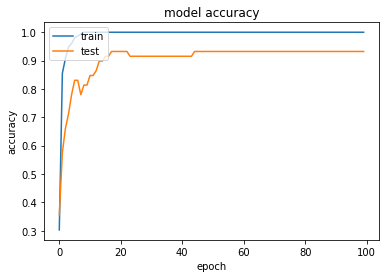

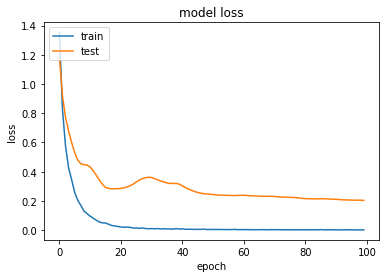

In [ ]:
# print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()